## 1. Setup and Configuration

In [1]:
# ==================================================
# PERFORMANCE ANALYSIS PIPELINE (Points & Top Scorer)
# ==================================================

# Cell 1: Setup
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
import os
import sys
from datetime import datetime
import optuna

# Sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False

# Configuration
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Paths
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations/performance_analysis')
DATASETS_DIR = Path('datasets')
# Assuming we have separate files or one file for both
POINTS_DATA_PATH = DATASETS_DIR / 'EPL(Overall Points & Ranking).csv' 
# If top scorer data is different, define it. Assuming same or similar.

REPORTS_DIR = Path('reports/performance_analysis')

# Create directories
for dir_path in [MODELS_DIR, VIZ_DIR, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Constants
RANDOM_STATE = 42

# ==================================================
# UTILITY FUNCTIONS
# ==================================================

def check_data_quality(df):
    """
    Perform comprehensive data quality check.
    """
    print("Data Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])
    print("\nDuplicate Rows:", df.duplicated().sum())
    
    # Check for constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print("\nConstant Columns (to drop):", constant_cols)
    else:
        print("\nNo constant columns found.")

def tune_hyperparameters(model_class, X_train, y_train, param_fn, n_trials=20, cv=5, scoring='f1_weighted', task_type='classification'):
    """
    Reusable Optuna hyperparameter tuning function.
    """
    def objective(trial):
        params = param_fn(trial)
        model = model_class(**params)
        
        if task_type == 'classification':
            cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
        else:
            cv_strategy = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
            
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
    return study.best_params

def evaluate_regression_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluate regression model and return metrics.
    """
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2_Score': r2
    }

def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot feature importance for tree-based models.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Adjust top_n to not exceed number of features
        n_features = len(feature_names)
        top_n = min(top_n, n_features)
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importances - {model_name}")
        plt.bar(range(top_n), importances[indices[:top_n]], align="center")
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
        plt.xlim([-1, top_n])
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importance plotting.")

print("="*80)
print("PERFORMANCE ANALYSIS PIPELINE")
print("="*80)
print(f"Setup completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"XGBoost Available: {XGB_AVAILABLE}")


PERFORMANCE ANALYSIS PIPELINE
Setup completed at: 2025-11-19 17:20:50
XGBoost Available: True


## 2. Total Points Prediction

### 2.1. Data Loading and Engineering (Total Points)

In [2]:
# Cell 2: Data Loading for Total Points
# ==================================================

def load_performance_data(file_path):
    """
    Load performance data with encoding handling.
    """
    print("\n" + "="*80)
    print("DATA LOADING")
    print("="*80)
    
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
    
    # Try different encodings and delimiters
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252', 'utf-16']
    df = None
    
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✓ Successfully loaded with encoding: {encoding}")
            break
        except Exception:
            try:
                # Try with different engine
                df = pd.read_csv(file_path, encoding=encoding, engine='python')
                print(f"✓ Successfully loaded with encoding: {encoding} (python engine)")
                break
            except Exception:
                continue
    
    if df is None:
        # Fall back to using the league winner dataset which has total points
        print(f"⚠ Could not load {file_path}")
        alt_path = DATASETS_DIR / 'ScoreSight_ML_Season_LeagueWinner_Champion.csv'
        print(f"Using alternative dataset: {alt_path}")
        df = pd.read_csv(alt_path)
        
    # Standardize
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    # Quality Check
    check_data_quality(df)
    
    print("\nColumns:", df.columns.tolist())
    print(f"Data shape: {df.shape}")
    
    return df

df = load_performance_data(POINTS_DATA_PATH)



DATA LOADING
✓ Successfully loaded with encoding: utf-16
Data Shape: (646, 13)

Missing Values:
 champion    602
notes       320
dtype: int64

Duplicate Rows: 0

No constant columns found.

Columns: ['season_end_year', 'team', 'position', 'champion', 'played', 'won', 'drawn', 'lost', 'gf', 'ga', 'gd', 'points', 'notes']
Data shape: (646, 13)



EDA FOR POINTS

Distribution of points:


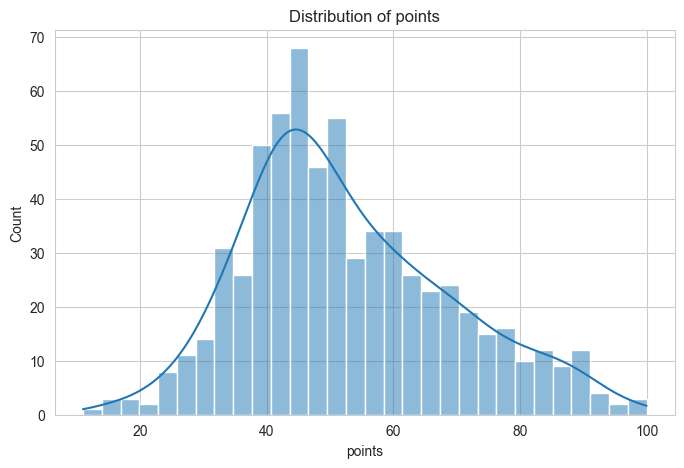


points Statistics:
count    646.000000
mean      52.654799
std       16.499190
min       11.000000
25%       41.000000
50%       50.000000
75%       63.000000
max      100.000000
Name: points, dtype: float64


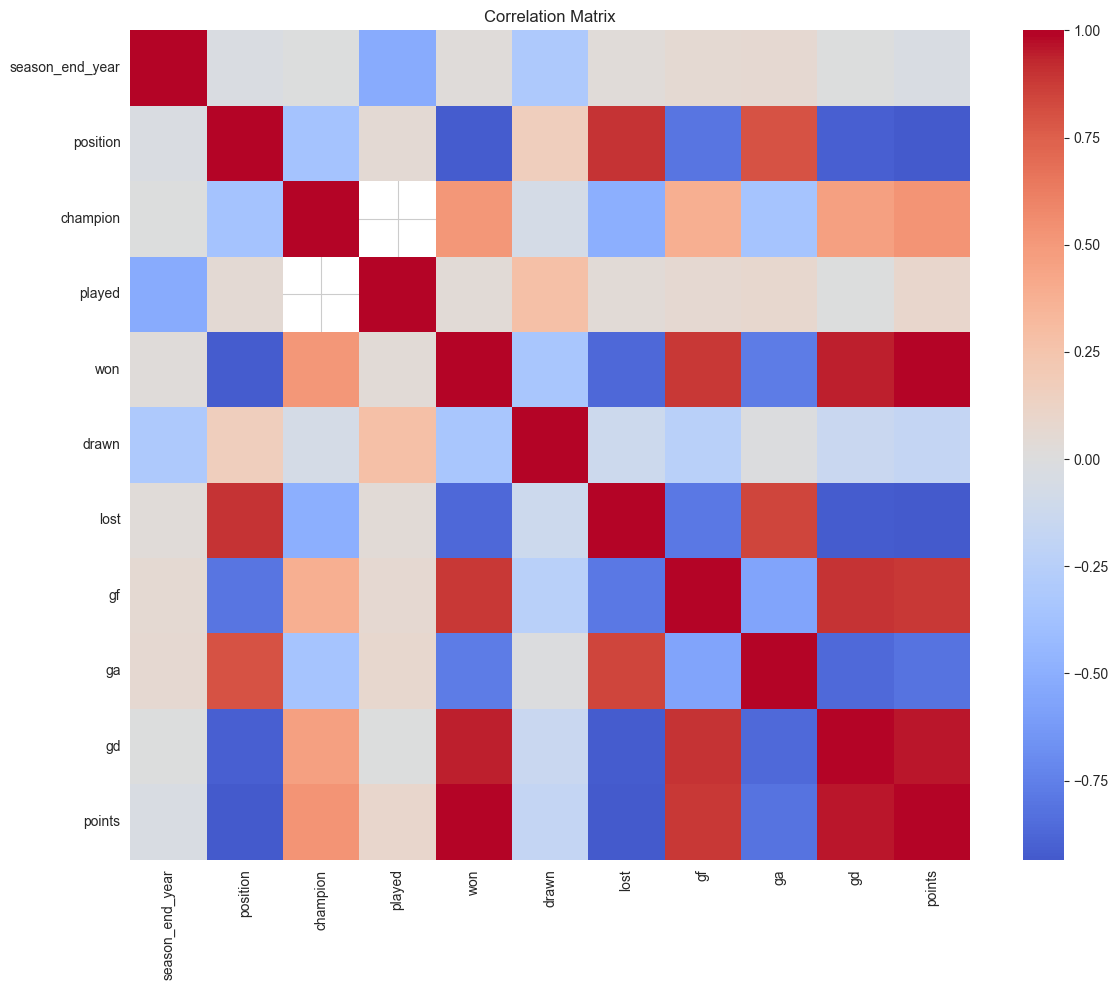


Top correlations with points:
points             1.000000
won                0.984925
gd                 0.958271
gf                 0.879260
champion           0.529049
played             0.085808
season_end_year   -0.031320
drawn             -0.174116
ga                -0.809380
lost              -0.932318
Name: points, dtype: float64


In [3]:
# Cell 3: EDA for Total Points
# ==================================================

def perform_performance_eda(df, target_col):
    """
    EDA for regression tasks.
    """
    print("\n" + "="*80)
    print(f"EDA FOR {target_col.upper()}")
    print("="*80)
    
    if target_col not in df.columns:
        print(f"Warning: Target '{target_col}' not found in dataset")
        return
    
    # Distribution of target
    print(f"\nDistribution of {target_col}:")
    plt.figure(figsize=(8, 5))
    sns.histplot(df[target_col], kde=True, bins=30)
    plt.title(f'Distribution of {target_col}')
    plt.xlabel(target_col)
    plt.show()
    
    # Basic statistics
    print(f"\n{target_col} Statistics:")
    print(df[target_col].describe())
        
    # Correlations
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty and target_col in numeric_df.columns:
        plt.figure(figsize=(12, 10))
        corr_matrix = numeric_df.corr()
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        # Top correlations with target
        print(f"\nTop correlations with {target_col}:")
        print(corr_matrix[target_col].sort_values(ascending=False).head(10))

# Perform EDA - look for total points column
points_target = None
for col in ['total_points', 'points', 'pts', 'target_total_points']:
    if col in df.columns:
        points_target = col
        break

if points_target:
    perform_performance_eda(df, points_target)
else:
    print("No points column found in dataset. Available columns:", df.columns.tolist())


### 2.2. Feature Engineering (Total Points)

In [4]:
# Cell 4: Feature Engineering for Total Points
# ==================================================

def preprocess_points_data(df, target_col):
    """
    Preprocess data for total points prediction.
    """
    print(f"\n{'='*80}")
    print(f"FEATURE ENGINEERING FOR {target_col.upper()}")
    print(f"{'='*80}")
    
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataset")
    
    data = df.copy()
    
    # Drop rows with NaN in target
    initial_rows = len(data)
    data = data.dropna(subset=[target_col])
    print(f"Dropped {initial_rows - len(data)} rows with NaN in target '{target_col}'")
    
    # Drop target-related columns that would cause leakage
    leakage_cols = ['rank', 'position', 'target_champion', 'target_top_4', 
                    'target_top_6', 'target_relegated', 'target_league_position', 
                    'champion', 'notes']
    # Drop non-predictive columns
    drop_cols = ['team', 'player', 'name', 'date', 'team_name'] + leakage_cols
    
    # Separate target
    y = data[target_col]
    X = data.drop(columns=[target_col])
    
    # Drop irrelevant columns
    dropped = [c for c in drop_cols if c in X.columns]
    X = X.drop(columns=dropped, errors='ignore')
    
    print("\n" + "-"*80)
    print("FEATURE SELECTION SUMMARY")
    print("-"*80)
    print(f"Target Column: '{target_col}'")
    print(f"\nExcluded Columns ({len(dropped)}): {dropped}")
    print(f"\nSelected Feature Columns ({len(X.columns)}):")
    for i, col in enumerate(X.columns, 1):
        print(f"  {i}. {col}")
    print("-"*80)
    
    # Handle missing values in features
    # For numeric columns, fill with median
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X[col].isnull().any():
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
            print(f"Filled {col} NaN values with median: {median_val:.2f}")
    
    # For categorical columns, fill with mode or 'Unknown'
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    for col in cat_cols:
        if X[col].isnull().any():
            X[col].fillna('Unknown', inplace=True)
            print(f"Filled {col} NaN values with 'Unknown'")
    
    # Encode categorical if any
    if cat_cols:
        print(f"Encoding categorical columns: {cat_cols}")
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # Split - temporal if season exists
    season_col = None
    for col in ['season', 'season_end_year']:
        if col in df.columns:
            season_col = col
            break
    
    if season_col:
        print(f"Using Temporal Split based on '{season_col}'...")
        # Get valid indices after cleaning
        valid_indices = data.index
        seasons = sorted(df.loc[valid_indices, season_col].unique())
        split_idx = int(len(seasons) * 0.8)
        train_seasons = seasons[:split_idx]
        test_seasons = seasons[split_idx:]
        
        print(f"Training Seasons: {train_seasons}")
        print(f"Test Seasons: {test_seasons}")
        
        train_mask = df.loc[valid_indices, season_col].isin(train_seasons)
        test_mask = df.loc[valid_indices, season_col].isin(test_seasons)
        
        X_train = X[train_mask]
        y_train = y[train_mask]
        X_test = X[test_mask]
        y_test = y[test_mask]
        
        # Drop season from features if present
        for col in [season_col, 'season', 'season_end_year']:
            if col in X_train.columns:
                X_train = X_train.drop(columns=[col])
                X_test = X_test.drop(columns=[col])
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    
    # Final check for NaN
    if X_train.isnull().any().any():
        print("Warning: NaN values still present, dropping remaining NaN rows...")
        valid_train = ~X_train.isnull().any(axis=1)
        X_train = X_train[valid_train]
        y_train = y_train[valid_train]
    
    if X_test.isnull().any().any():
        valid_test = ~X_test.isnull().any(axis=1)
        X_test = X_test[valid_test]
        y_test = y_test[valid_test]
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    print(f"\nTraining Shape: {X_train_scaled.shape}")
    print(f"Testing Shape: {X_test_scaled.shape}")
    print(f"Target range: {y.min():.2f} to {y.max():.2f}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Preprocess for total points
if points_target:
    X_train_points, X_test_points, y_train_points, y_test_points, scaler_points = preprocess_points_data(df, points_target)
else:
    print("Skipping preprocessing - no points target found")
    X_train_points, X_test_points, y_train_points, y_test_points = None, None, None, None



FEATURE ENGINEERING FOR POINTS
Dropped 0 rows with NaN in target 'points'

--------------------------------------------------------------------------------
FEATURE SELECTION SUMMARY
--------------------------------------------------------------------------------
Target Column: 'points'

Excluded Columns (4): ['team', 'position', 'champion', 'notes']

Selected Feature Columns (8):
  1. season_end_year
  2. played
  3. won
  4. drawn
  5. lost
  6. gf
  7. ga
  8. gd
--------------------------------------------------------------------------------
Using Temporal Split based on 'season_end_year'...
Training Seasons: [np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2

### 2.3. Model Training (Total Points)

In [5]:
# Cell 5: Train Models for Total Points
# ==================================================

def train_regression_models(X_train, y_train, model_prefix="total_points"):
    """
    Train regression models.
    """
    print("\n" + "="*80)
    print(f"MODEL TRAINING FOR {model_prefix.upper()}")
    print("="*80)
    
    best_models = {}
    
    # 1. Ridge Regression
    print("\n--- Tuning Ridge Regression ---")
    def ridge_params(trial):
        return {
            'alpha': trial.suggest_float('alpha', 0.1, 10.0, log=True),
            'random_state': RANDOM_STATE
        }
    ridge_best = tune_hyperparameters(
        Ridge, X_train, y_train, ridge_params, n_trials=15, 
        scoring='neg_mean_squared_error', task_type='regression'
    )
    ridge_model = Ridge(**ridge_best)
    ridge_model.fit(X_train, y_train)
    best_models['Ridge'] = ridge_model
    
    # 2. Random Forest Regressor
    print("\n--- Tuning Random Forest Regressor ---")
    def rf_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'max_depth': trial.suggest_int('max_depth', 5, 25),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    rf_best = tune_hyperparameters(
        RandomForestRegressor, X_train, y_train, rf_params, n_trials=20, 
        scoring='neg_mean_squared_error', task_type='regression'
    )
    rf_model = RandomForestRegressor(**rf_best)
    rf_model.fit(X_train, y_train)
    best_models['RandomForest'] = rf_model
    
    # 3. XGBoost Regressor (if available)
    if XGB_AVAILABLE:
        print("\n--- Tuning XGBoost Regressor ---")
        def xgb_params(trial):
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 400),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'random_state': RANDOM_STATE,
                'n_jobs': -1
            }
        xgb_best = tune_hyperparameters(
            xgb.XGBRegressor, X_train, y_train, xgb_params, n_trials=20, 
            scoring='neg_mean_squared_error', task_type='regression'
        )
        xgb_model = xgb.XGBRegressor(**xgb_best)
        xgb_model.fit(X_train, y_train)
        best_models['XGBoost'] = xgb_model
        
    return best_models

# Train models for Total Points
if X_train_points is not None:
    models_points = train_regression_models(X_train_points, y_train_points, "total_points")
else:
    print("Skipping Total Points model training - no data available")
    models_points = {}

[I 2025-11-19 17:20:50,627] A new study created in memory with name: no-name-d3516a2f-e861-4cc6-8949-a02266dd64e0



MODEL TRAINING FOR TOTAL_POINTS

--- Tuning Ridge Regression ---


[I 2025-11-19 17:20:54,479] Trial 0 finished with value: -0.1800377039766496 and parameters: {'alpha': 0.33358502207735624}. Best is trial 0 with value: -0.1800377039766496.
[I 2025-11-19 17:20:58,525] Trial 1 finished with value: -0.18002948860564327 and parameters: {'alpha': 0.33159409429163705}. Best is trial 1 with value: -0.18002948860564327.
[I 2025-11-19 17:20:58,525] Trial 1 finished with value: -0.18002948860564327 and parameters: {'alpha': 0.33159409429163705}. Best is trial 1 with value: -0.18002948860564327.
[I 2025-11-19 17:21:01,215] Trial 2 finished with value: -0.26637307120257847 and parameters: {'alpha': 4.2385708355504255}. Best is trial 1 with value: -0.18002948860564327.
[I 2025-11-19 17:21:01,215] Trial 2 finished with value: -0.26637307120257847 and parameters: {'alpha': 4.2385708355504255}. Best is trial 1 with value: -0.18002948860564327.
[I 2025-11-19 17:21:06,321] Trial 3 finished with value: -0.18025807793816842 and parameters: {'alpha': 0.3834112506899495}.

Best trial:
  Value: -0.17939103497660872
  Params: 
    alpha: 0.1017010603948268

--- Tuning Random Forest Regressor ---


[I 2025-11-19 17:21:07,845] Trial 0 finished with value: -2.0256609961436753 and parameters: {'n_estimators': 204, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: -2.0256609961436753.
[I 2025-11-19 17:21:09,428] Trial 1 finished with value: -2.033452625733839 and parameters: {'n_estimators': 326, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: -2.0256609961436753.
[I 2025-11-19 17:21:09,428] Trial 1 finished with value: -2.033452625733839 and parameters: {'n_estimators': 326, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: -2.0256609961436753.
[I 2025-11-19 17:21:10,831] Trial 2 finished with value: -3.093733742489263 and parameters: {'n_estimators': 154, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: -2.0256609961436753.
[I 2025-11-19 17:21:10,831] Trial 2 finished with value: -3.093733742489263 and parameter

Best trial:
  Value: -1.8911958852035582
  Params: 
    n_estimators: 181
    max_depth: 25
    min_samples_split: 3
    min_samples_leaf: 1


[I 2025-11-19 17:21:19,459] A new study created in memory with name: no-name-8c98ebc8-485f-4d96-8e3e-7b3fbfcd54c4



--- Tuning XGBoost Regressor ---


[I 2025-11-19 17:21:19,838] Trial 0 finished with value: -2.040524959564209 and parameters: {'n_estimators': 192, 'max_depth': 5, 'learning_rate': 0.1325431329673589, 'subsample': 0.7910309539472897, 'colsample_bytree': 0.6214861495482359}. Best is trial 0 with value: -2.040524959564209.
[I 2025-11-19 17:21:20,310] Trial 1 finished with value: -1.242793619632721 and parameters: {'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.031529441094558575, 'subsample': 0.9120118770779496, 'colsample_bytree': 0.9981266463881093}. Best is trial 1 with value: -1.242793619632721.
[I 2025-11-19 17:21:20,310] Trial 1 finished with value: -1.242793619632721 and parameters: {'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.031529441094558575, 'subsample': 0.9120118770779496, 'colsample_bytree': 0.9981266463881093}. Best is trial 1 with value: -1.242793619632721.
[I 2025-11-19 17:21:20,750] Trial 2 finished with value: -1.4672049760818482 and parameters: {'n_estimators': 257, 'max_depth': 6

Best trial:
  Value: -0.9185617923736572
  Params: 
    n_estimators: 400
    max_depth: 3
    learning_rate: 0.20079574351550958
    subsample: 0.7308662700104326
    colsample_bytree: 0.7577778249965752


### 2.4. Model Evaluation (Total Points)


MODEL EVALUATION - TOTAL POINTS

Evaluating Ridge for Total Points
--- Ridge (Points) Evaluation ---
MAE: 0.1255
MSE: 0.5659
RMSE: 0.7522
R2 Score: 0.9984


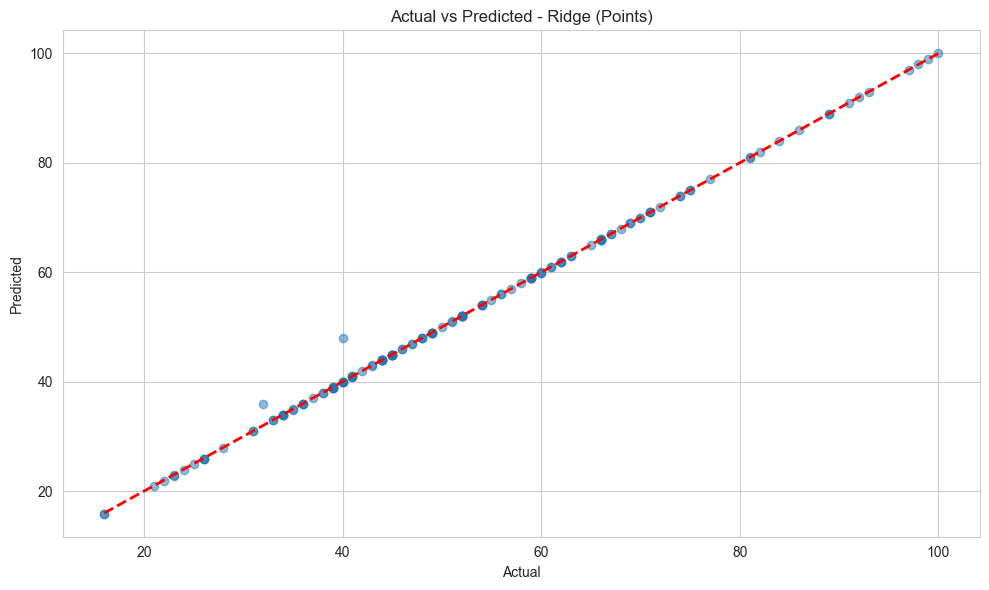

✓ Model saved to: models\ps3_total_points_Ridge.joblib

Evaluating RandomForest for Total Points
--- RandomForest (Points) Evaluation ---
MAE: 1.1190
MSE: 3.6424
RMSE: 1.9085
R2 Score: 0.9894


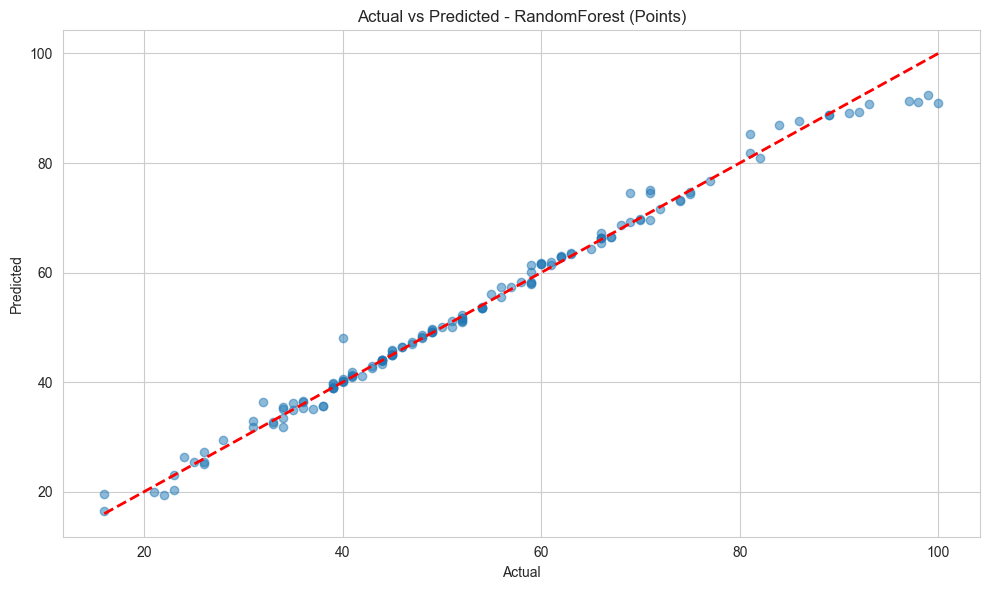


Feature Importance for RandomForest:


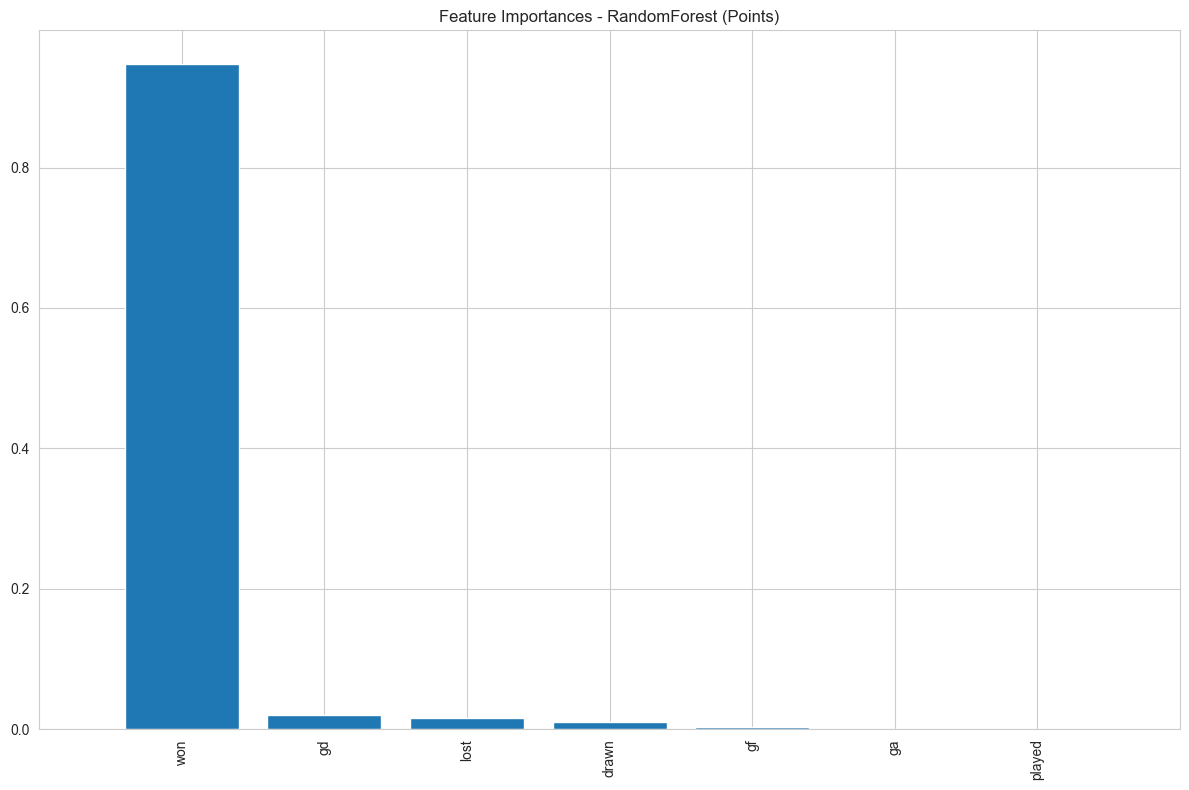

✓ Model saved to: models\ps3_total_points_RandomForest.joblib

Evaluating XGBoost for Total Points
--- XGBoost (Points) Evaluation ---
MAE: 0.6089
MSE: 1.6421
RMSE: 1.2815
R2 Score: 0.9952


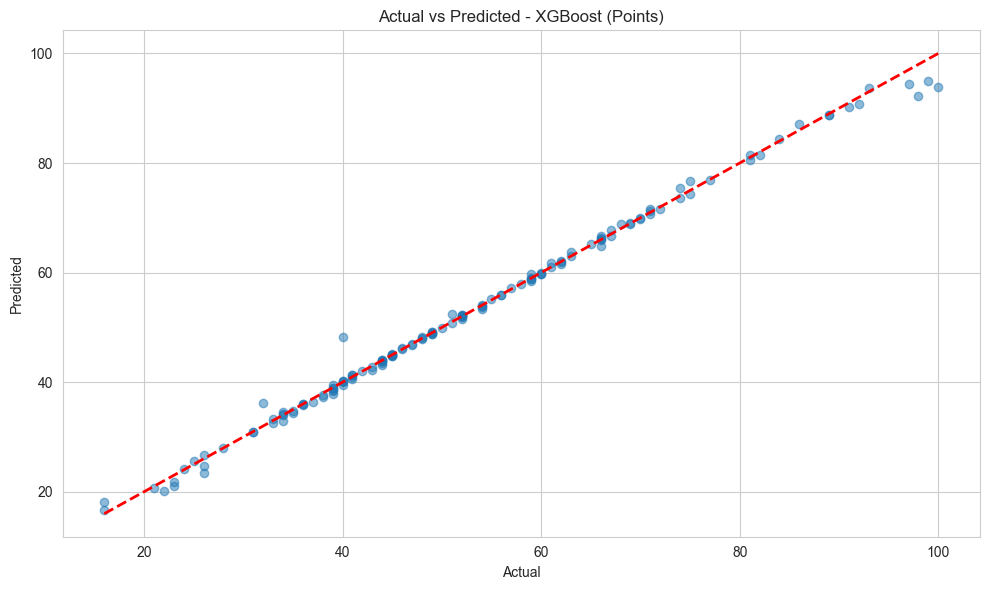


Feature Importance for XGBoost:


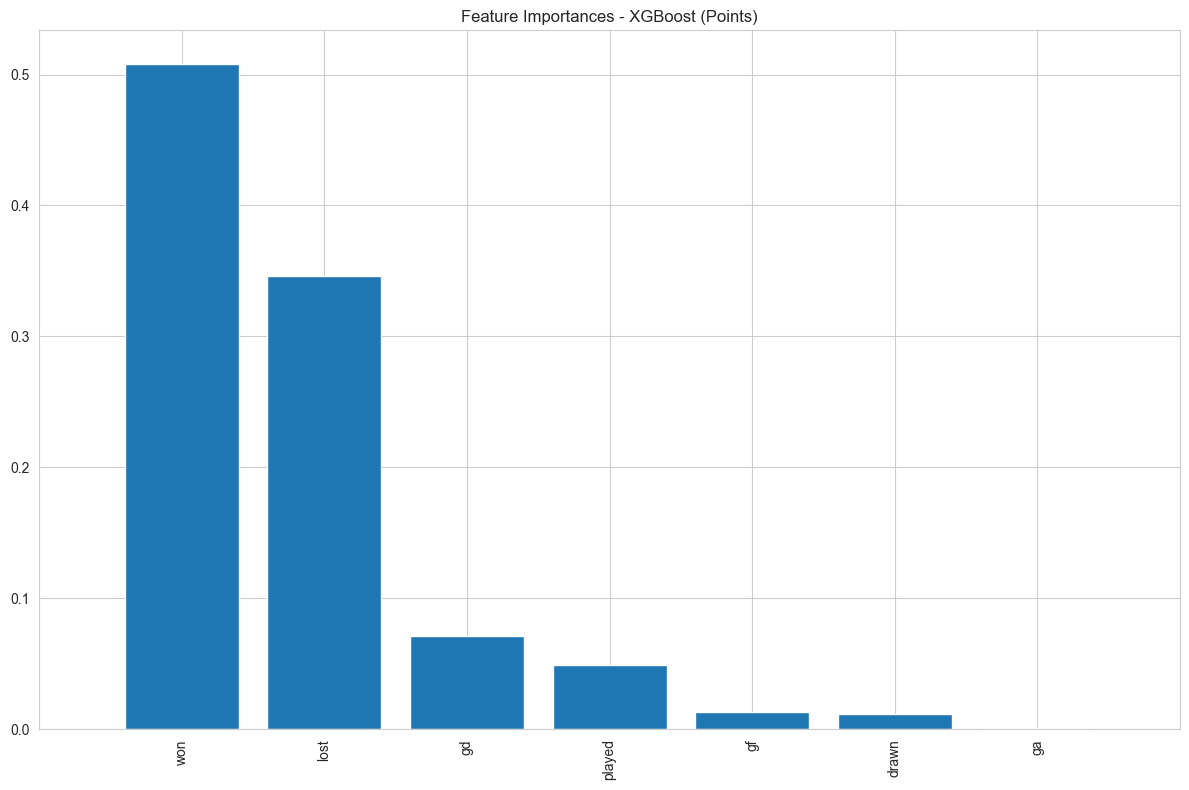

✓ Model saved to: models\ps3_total_points_XGBoost.joblib

TOTAL POINTS MODEL COMPARISON
                Model      MAE      MSE     RMSE  R2_Score
       Ridge (Points) 0.125532 0.565865 0.752240  0.998359
RandomForest (Points) 1.119013 3.642420 1.908512  0.989436
     XGBoost (Points) 0.608919 1.642146 1.281463  0.995237

✓ Comparison saved to: reports\performance_analysis\total_points_model_comparison.csv

🏆 Best Model: Ridge (Points)
   R² Score: 0.9984
✓ Best model saved to: models\ps3_total_points_best_model.joblib
✓ Metadata saved to: models\ps3_total_points_metadata.json


In [6]:
# Cell 6: Evaluate Models for Total Points
# ==================================================

print("\n" + "="*80)
print("MODEL EVALUATION - TOTAL POINTS")
print("="*80)

results_points = []

if models_points:
    for name, model in models_points.items():
        print(f"\n{'='*60}")
        print(f"Evaluating {name} for Total Points")
        print(f"{'='*60}")
        metrics = evaluate_regression_model(model, X_test_points, y_test_points, model_name=f"{name} (Points)")
        results_points.append(metrics)
        
        # Feature Importance for tree-based models
        if name in ['RandomForest', 'XGBoost']:
            print(f"\nFeature Importance for {name}:")
            plot_feature_importance(model, X_train_points.columns, top_n=20, model_name=f"{name} (Points)")
        
        # Save model
        model_path = MODELS_DIR / f'ps3_total_points_{name}.joblib'
        joblib.dump(model, model_path)
        print(f"✓ Model saved to: {model_path}")
    
    # Comparison Table
    results_points_df = pd.DataFrame(results_points)
    print("\n" + "="*80)
    print("TOTAL POINTS MODEL COMPARISON")
    print("="*80)
    print(results_points_df.to_string(index=False))
    results_points_df.to_csv(REPORTS_DIR / 'total_points_model_comparison.csv', index=False)
    print(f"\n✓ Comparison saved to: {REPORTS_DIR / 'total_points_model_comparison.csv'}")
    
    # Identify best model
    best_model_name = results_points_df.loc[results_points_df['R2_Score'].idxmax(), 'Model']
    best_model = models_points[best_model_name.split(' ')[0]]  # Extract model name
    
    # Save best model
    best_model_path = MODELS_DIR / 'ps3_total_points_best_model.joblib'
    joblib.dump(best_model, best_model_path)
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"   R² Score: {results_points_df.loc[results_points_df['R2_Score'].idxmax(), 'R2_Score']:.4f}")
    print(f"✓ Best model saved to: {best_model_path}")
    
    # Save metadata
    metadata_points = {
        'pipeline': 'Total Points Prediction',
        'problem_statement': 'PS3 - Total Points',
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'best_model': best_model_name,
        'metrics': results_points_df[results_points_df['R2_Score'] == results_points_df['R2_Score'].max()].to_dict('records')[0],
        'all_results': results_points_df.to_dict('records'),
        'features_used': X_train_points.columns.tolist(),
        'target_column': points_target,
        'random_state': RANDOM_STATE
    }
    
    import json
    metadata_path = MODELS_DIR / 'ps3_total_points_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata_points, f, indent=2, default=str)
    print(f"✓ Metadata saved to: {metadata_path}")
else:
    print("No models to evaluate for Total Points")


## 3. Top Scorer Prediction

### 3.1. Data Loading and Engineering (Top Scorer)

In [7]:
# Cell 8: Load Data for Top Scorer
# ==================================================

print("\n" + "="*80)
print("TOP SCORER DATA LOADING")
print("="*80)

# Define path to top scorer data
DATA_DIR = Path('data')
TOP_SCORER_PATH = DATA_DIR / 'top_scorer' / 'top_scorer_data.csv'

# Try to load the top scorer dataset
if TOP_SCORER_PATH.exists():
    print(f"✓ Loading Top Scorer data from: {TOP_SCORER_PATH}")
    df_scorer = load_performance_data(TOP_SCORER_PATH)
    
    # Check for goals column
    top_scorer_cols = ['goals', 'goals_scored', 'player_goals', 'target_goals']
    scorer_target = None
    
    for col in top_scorer_cols:
        if col in df_scorer.columns:
            scorer_target = col
            break
    
    if scorer_target:
        print(f"✓ Found top scorer target: '{scorer_target}'")
        print(f"\nDataset shape: {df_scorer.shape}")
        print(f"Target column: '{scorer_target}'")
        print(f"Target range: {df_scorer[scorer_target].min()} to {df_scorer[scorer_target].max()}")
    else:
        print("⚠ No goals column found in top scorer dataset")
        print(f"Available columns: {df_scorer.columns.tolist()}")
else:
    print(f"⚠ Top Scorer data file not found at: {TOP_SCORER_PATH}")
    print("Checking alternative locations...")
    
    # Try alternative paths
    alt_paths = [
        DATASETS_DIR / 'top_scorer_data.csv',
        DATASETS_DIR / 'player_stats.csv',
        DATA_DIR / 'top_scorer_data.csv'
    ]
    
    df_scorer = None
    scorer_target = None
    top_scorer_cols = ['goals', 'goals_scored', 'player_goals', 'target_goals']
    
    for path in alt_paths:
        if path.exists():
            print(f"✓ Loading alternative dataset: {path}")
            df_scorer = load_performance_data(path)
            
            # Check for goals column
            for col in top_scorer_cols:
                if col in df_scorer.columns:
                    scorer_target = col
                    print(f"✓ Found top scorer target: '{scorer_target}' in {path.name}")
                    break
            if scorer_target:
                break
    
    if df_scorer is None or scorer_target is None:
        print("⚠ No suitable dataset found for Top Scorer prediction")
        print("Cannot proceed with Top Scorer - no goals data available")


TOP SCORER DATA LOADING
✓ Loading Top Scorer data from: data\top_scorer\top_scorer_data.csv

DATA LOADING
✓ Successfully loaded with encoding: utf-8
Data Shape: (2274, 8)

Missing Values:
 Series([], dtype: int64)

Duplicate Rows: 870

No constant columns found.

Columns: ['goals_+_assists', 'penalty_attempts', 'xg', 'npxg', 'progressive_receives', 'non_penalty_goals_per_90', 'non_penalty_goals_+_assists_per_90', 'goals']
Data shape: (2274, 8)
✓ Found top scorer target: 'goals'

Dataset shape: (2274, 8)
Target column: 'goals'
Target range: 0 to 29


### 3.2. EDA (Top Scorer)


EDA FOR GOALS

Distribution of goals:


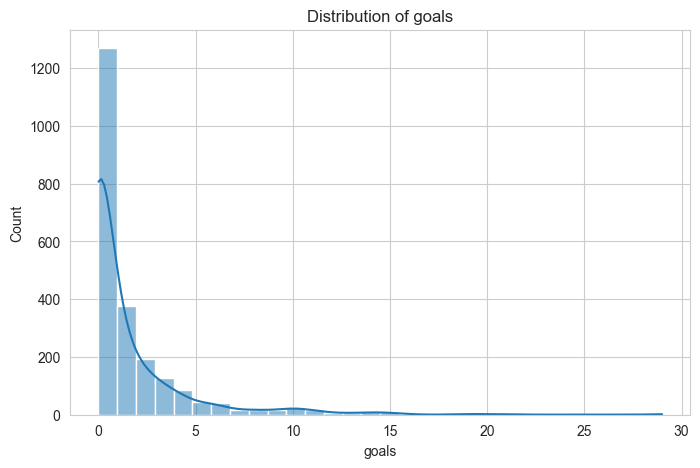


goals Statistics:
count    2274.000000
mean        1.566403
std         3.124944
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        29.000000
Name: goals, dtype: float64


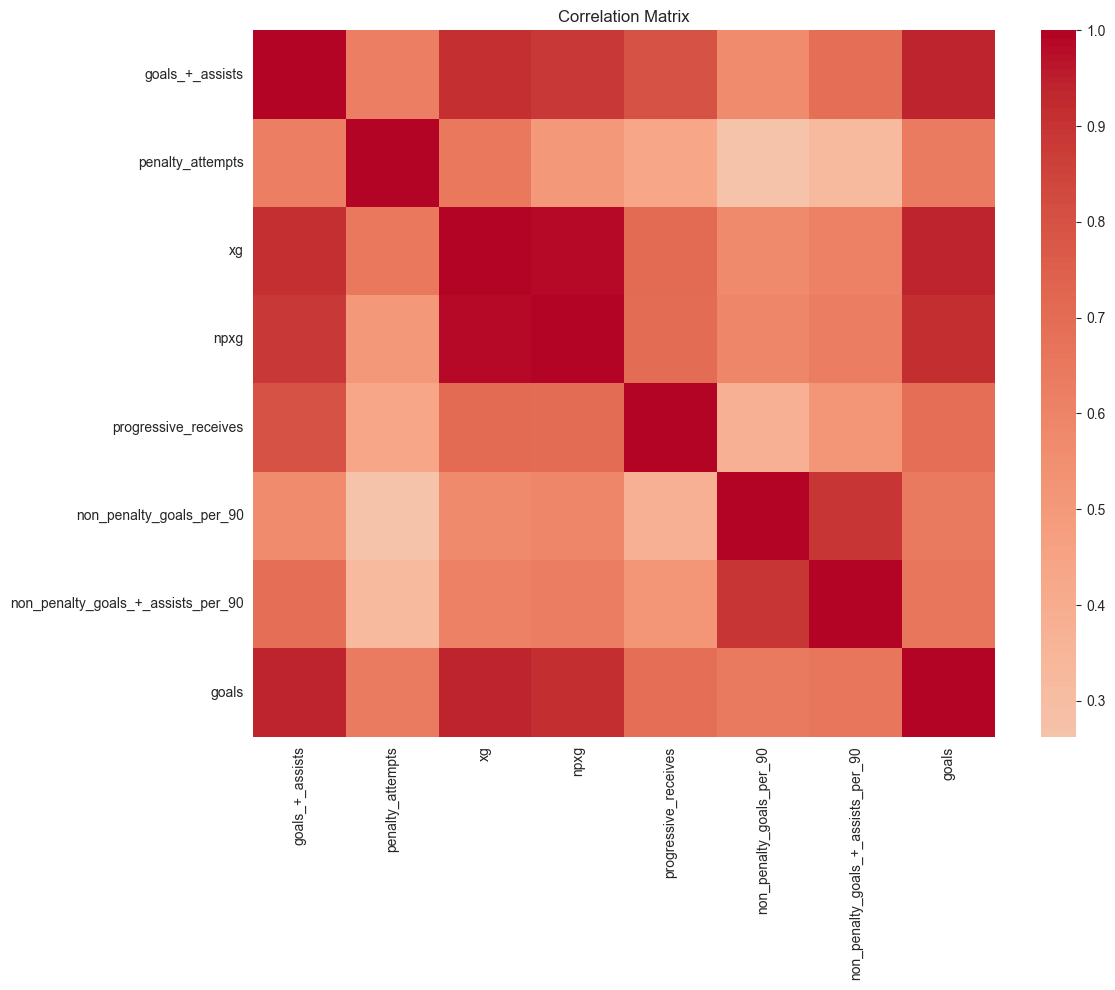


Top correlations with goals:
goals                                 1.000000
goals_+_assists                       0.941197
xg                                    0.940149
npxg                                  0.919148
progressive_receives                  0.690770
non_penalty_goals_+_assists_per_90    0.660468
non_penalty_goals_per_90              0.640701
penalty_attempts                      0.638183
Name: goals, dtype: float64


In [8]:
# Cell 9: EDA for Top Scorer
# ==================================================

if scorer_target and df_scorer is not None:
    perform_performance_eda(df_scorer, scorer_target)
else:
    print("Skipping Top Scorer EDA - no suitable data available")

### 3.3. Feature Engineering (Top Scorer)

In [9]:
# Cell 10: Feature Engineering for Top Scorer
# ==================================================

if scorer_target and df_scorer is not None:
    X_train_scorer, X_test_scorer, y_train_scorer, y_test_scorer, scaler_scorer = preprocess_points_data(df_scorer, scorer_target)
else:
    print("Skipping Top Scorer preprocessing - no data available")
    X_train_scorer, X_test_scorer, y_train_scorer, y_test_scorer = None, None, None, None


FEATURE ENGINEERING FOR GOALS
Dropped 0 rows with NaN in target 'goals'

--------------------------------------------------------------------------------
FEATURE SELECTION SUMMARY
--------------------------------------------------------------------------------
Target Column: 'goals'

Excluded Columns (0): []

Selected Feature Columns (7):
  1. goals_+_assists
  2. penalty_attempts
  3. xg
  4. npxg
  5. progressive_receives
  6. non_penalty_goals_per_90
  7. non_penalty_goals_+_assists_per_90
--------------------------------------------------------------------------------

Training Shape: (1819, 7)
Testing Shape: (455, 7)
Target range: 0.00 to 29.00

Training Shape: (1819, 7)
Testing Shape: (455, 7)
Target range: 0.00 to 29.00


### 3.2. Model Training (Top Scorer)

In [10]:
# Cell 11: Train Models for Top Scorer
# ==================================================

if X_train_scorer is not None:
    models_scorer = train_regression_models(X_train_scorer, y_train_scorer, "top_scorer")
else:
    print("Skipping Top Scorer model training - no data available")
    models_scorer = {}

[I 2025-11-19 17:21:24,003] A new study created in memory with name: no-name-8b6e4071-6c8f-4fa8-b57d-9e2dd79f68c6
[I 2025-11-19 17:21:24,029] Trial 0 finished with value: -0.37225910001538787 and parameters: {'alpha': 1.1788879230665834}. Best is trial 0 with value: -0.37225910001538787.
[I 2025-11-19 17:21:24,029] Trial 0 finished with value: -0.37225910001538787 and parameters: {'alpha': 1.1788879230665834}. Best is trial 0 with value: -0.37225910001538787.
[I 2025-11-19 17:21:24,054] Trial 1 finished with value: -0.37230626568881003 and parameters: {'alpha': 1.9429132126773203}. Best is trial 0 with value: -0.37225910001538787.
[I 2025-11-19 17:21:24,067] Trial 2 finished with value: -0.37225856542589914 and parameters: {'alpha': 1.0086988881497048}. Best is trial 2 with value: -0.37225856542589914.
[I 2025-11-19 17:21:24,054] Trial 1 finished with value: -0.37230626568881003 and parameters: {'alpha': 1.9429132126773203}. Best is trial 0 with value: -0.37225910001538787.
[I 2025-11-


MODEL TRAINING FOR TOP_SCORER

--- Tuning Ridge Regression ---


[I 2025-11-19 17:21:24,204] Trial 11 finished with value: -0.3724444885215378 and parameters: {'alpha': 0.12351999144410944}. Best is trial 2 with value: -0.37225856542589914.
[I 2025-11-19 17:21:24,219] Trial 12 finished with value: -0.37282381119557545 and parameters: {'alpha': 4.2899808841903475}. Best is trial 2 with value: -0.37225856542589914.
[I 2025-11-19 17:21:24,219] Trial 12 finished with value: -0.37282381119557545 and parameters: {'alpha': 4.2899808841903475}. Best is trial 2 with value: -0.37225856542589914.
[I 2025-11-19 17:21:24,236] Trial 13 finished with value: -0.3723014772942571 and parameters: {'alpha': 0.42030662475190766}. Best is trial 2 with value: -0.37225856542589914.
[I 2025-11-19 17:21:24,253] Trial 14 finished with value: -0.37236482024069445 and parameters: {'alpha': 0.2152572968466473}. Best is trial 2 with value: -0.37225856542589914.
[I 2025-11-19 17:21:24,236] Trial 13 finished with value: -0.3723014772942571 and parameters: {'alpha': 0.42030662475190

Best trial:
  Value: -0.37225856542589914
  Params: 
    alpha: 1.0086988881497048

--- Tuning Random Forest Regressor ---


[I 2025-11-19 17:21:24,490] Trial 0 finished with value: -0.24827553757249046 and parameters: {'n_estimators': 131, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.24827553757249046.
[I 2025-11-19 17:21:24,828] Trial 1 finished with value: -0.3121243987165939 and parameters: {'n_estimators': 197, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.24827553757249046.
[I 2025-11-19 17:21:24,828] Trial 1 finished with value: -0.3121243987165939 and parameters: {'n_estimators': 197, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.24827553757249046.
[I 2025-11-19 17:21:25,369] Trial 2 finished with value: -0.2889268630173807 and parameters: {'n_estimators': 348, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: -0.24827553757249046.
[I 2025-11-19 17:21:25,369] Trial 2 finished with value: -0.2889268630173807 a

Best trial:
  Value: -0.2328460111873393
  Params: 
    n_estimators: 268
    max_depth: 11
    min_samples_split: 3
    min_samples_leaf: 1


[I 2025-11-19 17:21:33,503] A new study created in memory with name: no-name-ce51ee26-138f-44eb-a8c2-d02fa9951b26



--- Tuning XGBoost Regressor ---


[I 2025-11-19 17:21:33,901] Trial 0 finished with value: -0.25378178358078 and parameters: {'n_estimators': 392, 'max_depth': 10, 'learning_rate': 0.1290754691422591, 'subsample': 0.6769521549952109, 'colsample_bytree': 0.6255540982636902}. Best is trial 0 with value: -0.25378178358078.
[I 2025-11-19 17:21:34,136] Trial 1 finished with value: -0.2712522238492966 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.2799225176644678, 'subsample': 0.7051808641242682, 'colsample_bytree': 0.6309939836588789}. Best is trial 0 with value: -0.25378178358078.
[I 2025-11-19 17:21:34,136] Trial 1 finished with value: -0.2712522238492966 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.2799225176644678, 'subsample': 0.7051808641242682, 'colsample_bytree': 0.6309939836588789}. Best is trial 0 with value: -0.25378178358078.
[I 2025-11-19 17:21:34,245] Trial 2 finished with value: -0.16782383769750595 and parameters: {'n_estimators': 335, 'max_depth': 3, 'l

Best trial:
  Value: -0.13758656233549119
  Params: 
    n_estimators: 339
    max_depth: 3
    learning_rate: 0.1856244299048076
    subsample: 0.8161747497082446
    colsample_bytree: 0.7220421609724836


### 3.5. Model Evaluation (Top Scorer)


MODEL EVALUATION - TOP SCORER

Evaluating Ridge for Top Scorer
--- Ridge (Scorer) Evaluation ---
MAE: 0.3953
MSE: 0.5396
RMSE: 0.7346
R2 Score: 0.9370


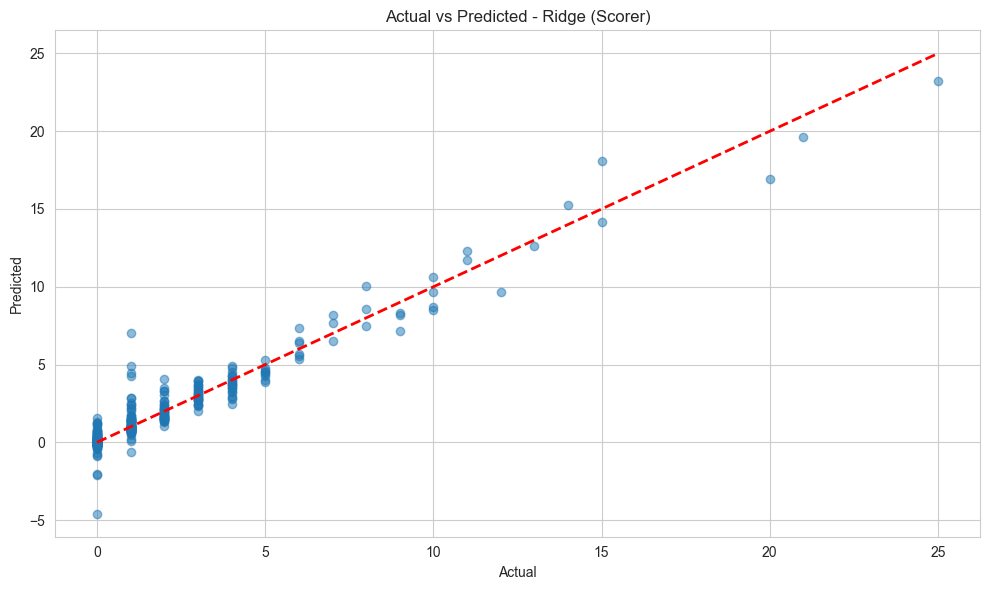

✓ Model saved to: models\ps2_top_scorer_Ridge.joblib

Evaluating RandomForest for Top Scorer
--- RandomForest (Scorer) Evaluation ---
MAE: 0.1789
MSE: 0.2771
RMSE: 0.5264
R2 Score: 0.9676


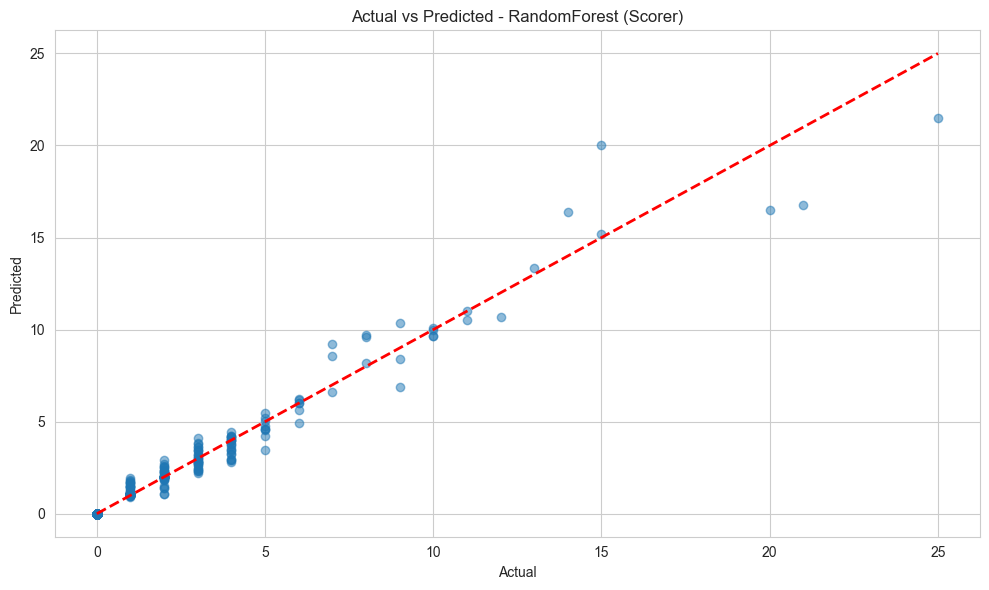


Feature Importance for RandomForest:


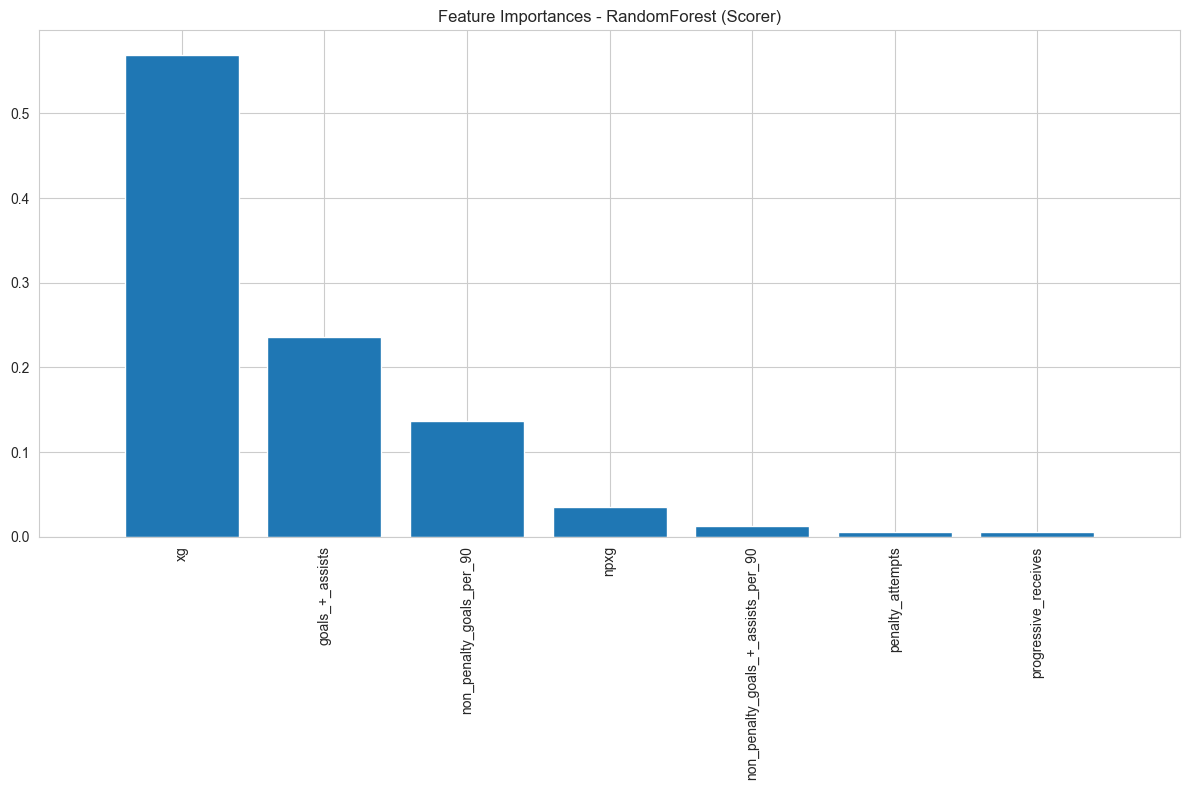

✓ Model saved to: models\ps2_top_scorer_RandomForest.joblib

Evaluating XGBoost for Top Scorer
--- XGBoost (Scorer) Evaluation ---
MAE: 0.1438
MSE: 0.1389
RMSE: 0.3728
R2 Score: 0.9838


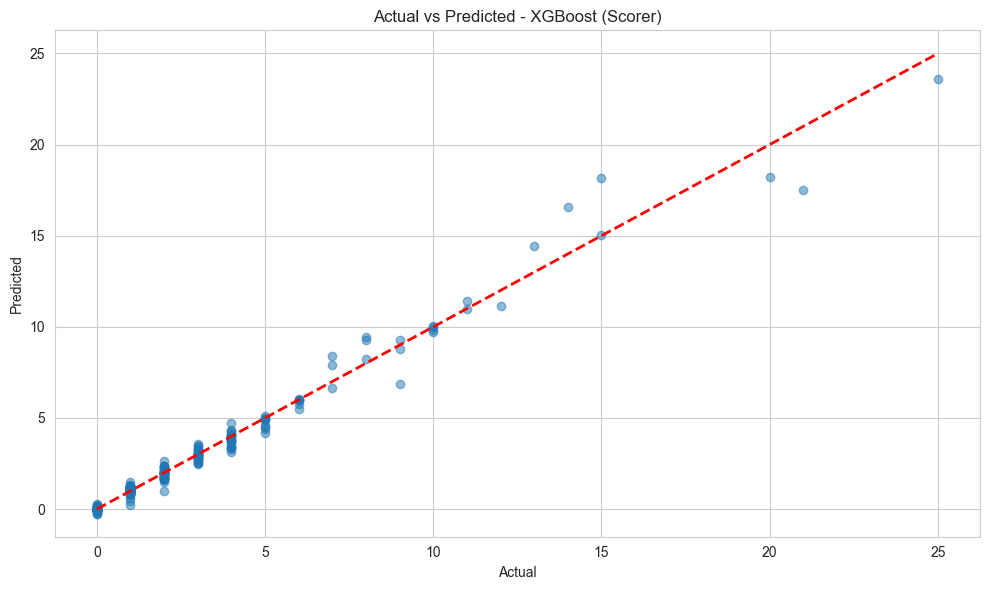


Feature Importance for XGBoost:


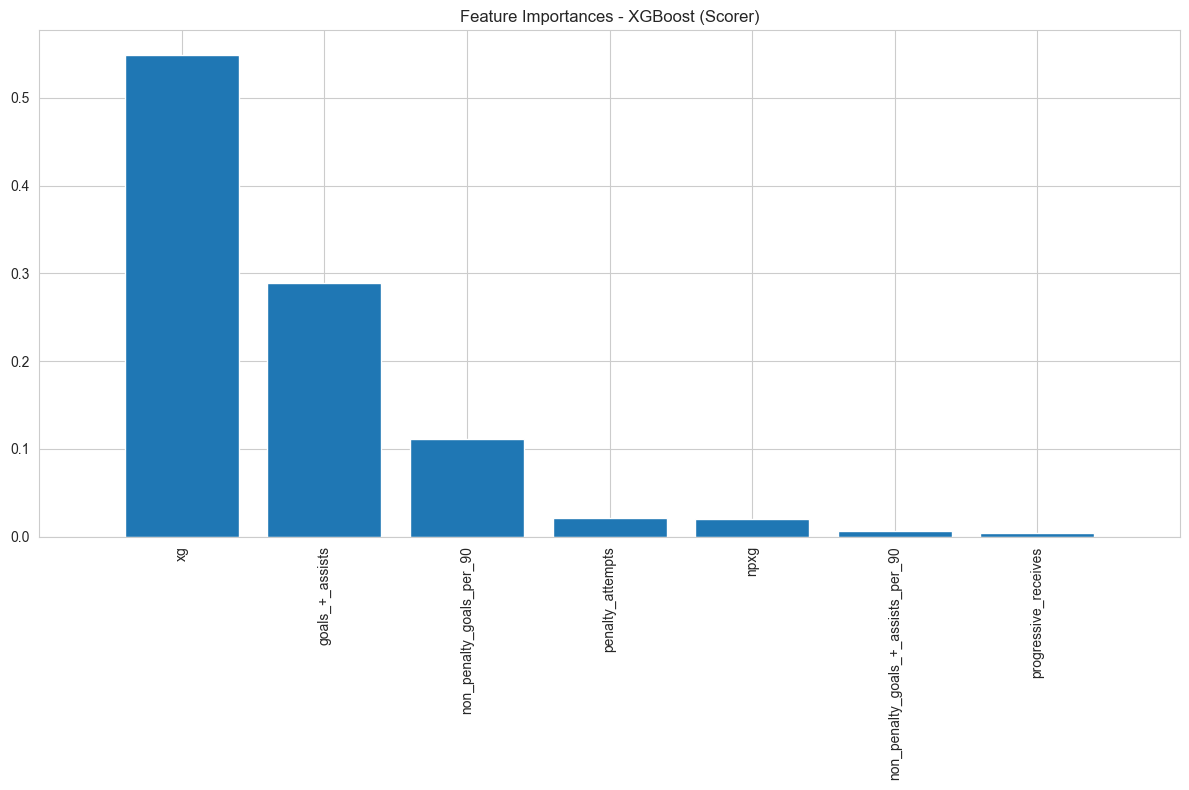

✓ Model saved to: models\ps2_top_scorer_XGBoost.joblib

TOP SCORER MODEL COMPARISON
                Model      MAE      MSE     RMSE  R2_Score
       Ridge (Scorer) 0.395325 0.539632 0.734596  0.936970
RandomForest (Scorer) 0.178929 0.277122 0.526424  0.967632
     XGBoost (Scorer) 0.143753 0.138946 0.372754  0.983771

✓ Comparison saved to: reports\performance_analysis\top_scorer_model_comparison.csv

🏆 Best Model: XGBoost (Scorer)
   R² Score: 0.9838
✓ Best model saved to: models\ps2_top_scorer_best_model.joblib
✓ Metadata saved to: models\ps2_top_scorer_metadata.json

✅ TOP SCORER & TOTAL POINTS PIPELINE COMPLETED!


In [11]:
# Cell 12: Evaluate Models for Top Scorer
# ==================================================

print("\n" + "="*80)
print("MODEL EVALUATION - TOP SCORER")
print("="*80)

results_scorer = []

if models_scorer:
    for name, model in models_scorer.items():
        print(f"\n{'='*60}")
        print(f"Evaluating {name} for Top Scorer")
        print(f"{'='*60}")
        metrics = evaluate_regression_model(model, X_test_scorer, y_test_scorer, model_name=f"{name} (Scorer)")
        results_scorer.append(metrics)
        
        # Feature Importance for tree-based models
        if name in ['RandomForest', 'XGBoost']:
            print(f"\nFeature Importance for {name}:")
            plot_feature_importance(model, X_train_scorer.columns, top_n=20, model_name=f"{name} (Scorer)")
        
        # Save model
        model_path = MODELS_DIR / f'ps2_top_scorer_{name}.joblib'
        joblib.dump(model, model_path)
        print(f"✓ Model saved to: {model_path}")
    
    # Comparison Table
    results_scorer_df = pd.DataFrame(results_scorer)
    print("\n" + "="*80)
    print("TOP SCORER MODEL COMPARISON")
    print("="*80)
    print(results_scorer_df.to_string(index=False))
    results_scorer_df.to_csv(REPORTS_DIR / 'top_scorer_model_comparison.csv', index=False)
    print(f"\n✓ Comparison saved to: {REPORTS_DIR / 'top_scorer_model_comparison.csv'}")
    
    # Identify best model
    best_model_name = results_scorer_df.loc[results_scorer_df['R2_Score'].idxmax(), 'Model']
    best_model = models_scorer[best_model_name.split(' ')[0]]  # Extract model name
    
    # Save best model
    best_model_path = MODELS_DIR / 'ps2_top_scorer_best_model.joblib'
    joblib.dump(best_model, best_model_path)
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"   R² Score: {results_scorer_df.loc[results_scorer_df['R2_Score'].idxmax(), 'R2_Score']:.4f}")
    print(f"✓ Best model saved to: {best_model_path}")
    
    # Save metadata
    metadata_scorer = {
        'pipeline': 'Top Scorer Prediction',
        'problem_statement': 'PS2 - Top Scorer',
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'best_model': best_model_name,
        'metrics': results_scorer_df[results_scorer_df['R2_Score'] == results_scorer_df['R2_Score'].max()].to_dict('records')[0],
        'all_results': results_scorer_df.to_dict('records'),
        'features_used': X_train_scorer.columns.tolist(),
        'target_column': scorer_target,
        'random_state': RANDOM_STATE
    }
    
    import json
    metadata_path = MODELS_DIR / 'ps2_top_scorer_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata_scorer, f, indent=2, default=str)
    print(f"✓ Metadata saved to: {metadata_path}")
else:
    print("No models to evaluate for Top Scorer")

print("\n" + "="*80)
print("✅ TOP SCORER & TOTAL POINTS PIPELINE COMPLETED!")
print("="*80)